# Loss computation in PYLEECAN

## Iron losses

### Theory

Iron losses are computed thanks to a Steinmetz equation. It takes into account the contribution of hysteresis and Eddy current losses. The coefficients of the equation must be fitted to experimental loss data for each material.
$$
	P = k_{hy} f^{\alpha_f} B^{\alpha_B} + k_{ed} f^2 B^2 
$$


+ $P$ is the loss density,
+ $k_{hy}$ and $k_{ed}$ are coefficients found by curve-fitting,
+ $f$ is the frequency of the magnetic fluc density,
+ $B$ is the amplitude of the magnetic flux density.

Several equations exist to compute iron losses. The one presented above seems to give the better correlation with the input data. For example, another well known formula is the Bertotti's one:

$$
  P = k_{hy} f B + k_{ed} f^2 B^2 + k_{ex} f^{1.5} B^{1.5}
$$

The two models have been implemented in PYLEECAN and it is possible to compare them.

### Implementation in PYLEECAN

The Steinmetz equation enables to compute the loss density in each element of the mesh, thanks to the value of the magnetic flux density $B$ given by the FEMM simulation.

The curve-fitting allowing to compute the coefficients have been implemented in PYLEECAN. The loss data of the material can be stored in an ImportMatrix in the material.

It is necessary to take into account the harmonics of $B$. Indeed, the Steinmetz equation enables to compute the losses when $B$ is sinusoidal. Thus, the Fourier transform of the magnetic flux density is used and the loss is the sum of the contribution of each harmonic:

$$
  P = \sum_{\nu = 0}^{N} \left( k_{hy} f_{\nu}^{\alpha_f} B_{\nu}^{\alpha_B} + k_{ed} f_{\nu}^2 B_{\nu}^2 \right)
$$
with $N$ the number of harmonics taken into account.

In this equation, the coefficients $k_{hy}$ and $k_{ed}$ found by curve-fitting are divided by the stacking factor of the lamination. 

## Magnet loss

The magnet losses are computed according to the method described in:
 D. Ishak, Z. Q. Zhu, et D. Howe, « Eddy-current loss in the rotor magnets of permanent-magnet brushless machines having a fractional number of slots per pole », IEEE Transactions on Magnetics, vol. 41, nᵒ 9, p. 2462‑2469, sept. 2005, doi: 10.1109/TMAG.2005.854337.
This method uses the current density $J$ in the magnets. This current density is calculated from the vector magnetic potential $A$ according to the following equation:
$$
  J_m = - \sigma_m \frac{\partial A}{\partial t} + J_c
$$


+ $\sigma_m$ is the magnet conductivity,
+ $J_c$ is an integration constant which imposes that the total current density in the magnet is null.

The current density in the magnets enables to compute the loss density in each element of the mesh according to the equation:

$$
  P = \frac{1}{2 \sigma_m} k_{seg} J_{mfft}^2
$$

with :
$$
  J_{mfft} = - j \sigma_m \omega (A_{zfft} - A_{zmean})
$$
The term $A_{zmean}$ correspond to the integration constant $J_c$.

$k_{seg}$ is a coefficient that allows to take magnet segmentation into account. Segmentation means that the magnets are divided in several blocks in the axial direction of the electrical machine. $k_{seg}$ is given by the following equation:

$$
  k_{seg} = {\left(\frac{L_{mag} + W_{mag}}{L_{mag} N_{seg} + W_{mag}}\right)}^2 
$$

with :

+ $L_{mag}$ the length of the magnets
+ $W_{mag}$ the width of the magnets
+ $N_{seg}$ the number of segments that consitute the magnets



## Skin effect
	
It is necessary to take skin effect into account to compute Joule losses. To achieve this, a coefficient that decreases the material conductivity is computed with respect to the electrical frequency. The following equation from J. Pyrhonen, T. Jokinen, et V. Hrabovcova, Design of Rotating Electrical Machines. John Wiley & Sons, 2013, enables to compute this coefficient:

$$
  \begin{cases}
    k_{skin} = 1 + 0.59 \times \frac{zt^2 - 0.2}{9} \times \xi^4 \quad \textrm{for circular conductors}\\
    k_{skin} = 1 + \frac{zt^2 - 0.2}{9} \times \xi^4 \quad \textrm{for rectangular conductors}
  \end{cases}
$$

with :

$$
  \xi = h_c  \sqrt{\frac{1}{2}  \omega  \mu_0  \mu_r  \sigma  z_a  \frac{bc_0}{b}}
$$

  + $h_c = z_p \times h_{c0}$
    - $z_p$ the number of adjacent wires in the radial direction,
    - $h_{c0}$ the height of the wires

  + $b_{c0}$ the width of the wires
  + $z_a$ the number of adjacent wires in the tangential directon

## Proximity effect losses

Proximity effect losses are caused by induced currents in the windings. Each conductor creates a magnetic field that induce curent in adjacent conductors. This is called proximity effect. To be computed precisely, it would require a fine modelling of each conductor in the slots. That is not the case in PYLEECAN. In the software, the whole slot is considered as a uniform soucre of current on all the active surface. Thus, the proximity effect loss is computed according to an approximation that takes the global magnetic flux density in the slots. The computation is done in the same way as eddy current losses in the iron. It uses the frequency and the amplitude of the flux density:

$$
  P = k_p f^2 B^2 
$$

with :

$$
  k_p = k_{sfill}\frac{\pi^2}{8} \sigma_{wire} d_{wire}^2 
$$

where :

+ $k_{sfill}$ is the filling factor of the slots
+ $\sigma_{wire}$ is the electrical conductivity of the conductors
+ $d_{wire}$ the diameter of the wires


### Version information

In [1]:
%matplotlib notebook
from PySide2.QtWidgets import *
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: April 27, 2023
Pyleecan version:1.5.0
SciDataTool version:2.5.0


# Validation case

The machine used for the validation of the loss models is taken from the FEMM website D. Meeker, « Rotating Losses in a Surface Mount Permanent Magnet Motor:Finite Element Method Magnetics ». https://www.femm.info/wiki/SPMLoss. It is a 60W surface permanent magnet synchronous machine (SPMSM) with 8 pole pairs and 18 stator slots. The machine is imported and plotted below.


<IPython.core.display.Javascript object>


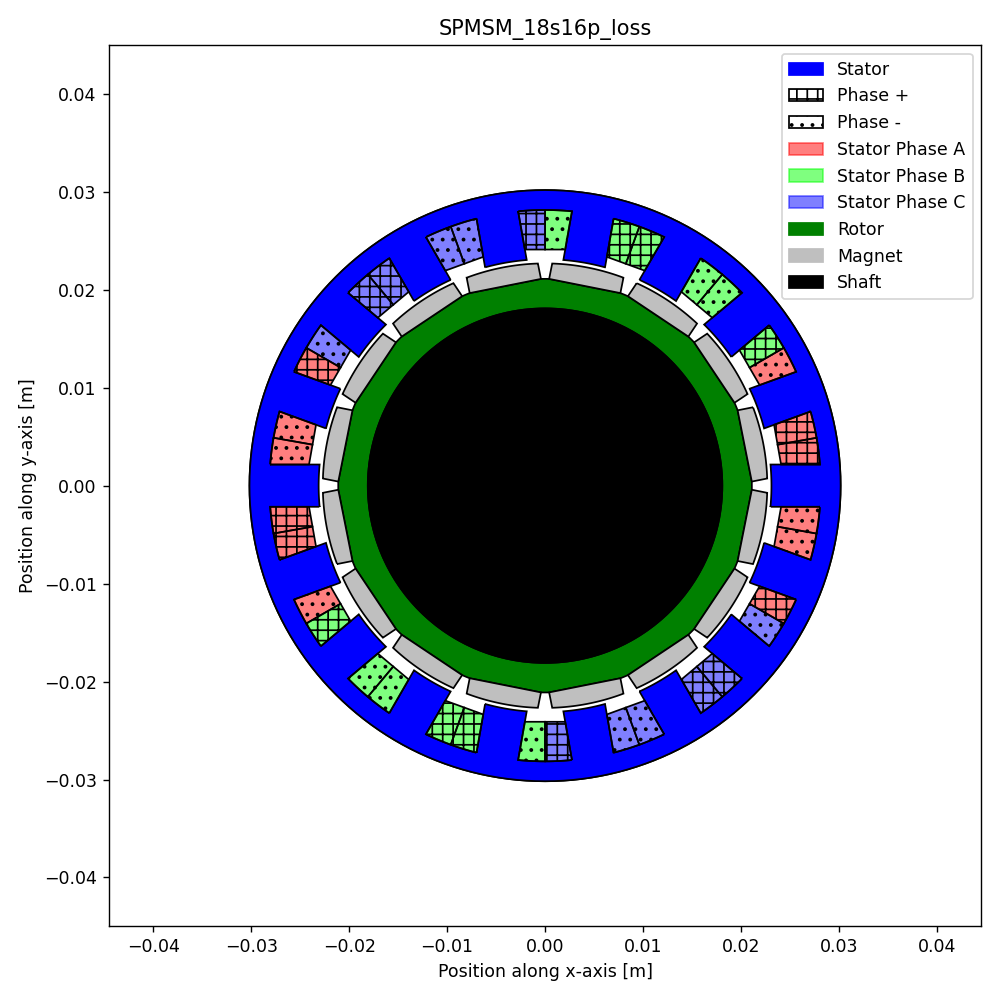

In [3]:
%matplotlib notebook
# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

machine = load(join(DATA_DIR, "Machine", "SPMSM_18s16p_loss.json"))
fig, ax = machine.plot()

The FEMM website provides two figures that can be reproduced in PYLEECAN.

![](./Images/loss_mesh_meeker.PNG)
![](./Images/loss_vs_speed_meeker.PNG)

To reproduce these figures, a simulation with the magnetic and loss module will be carried out. The definition of the magnetic part of the simulation is similar to the tutorial "[How to define a simulation to call FEMM](https://pyleecan.org/02_tuto_Simulation_FEMM.html)"

In [4]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.LossFEA import LossFEA
from pyleecan.Classes.LossModelSteinmetz import LossModelSteinmetz
from pyleecan.Classes.LossModelBertotti import LossModelBertotti
from pyleecan.Classes.LossModelWinding import LossModelWinding
from pyleecan.Classes.LossModelProximity import LossModelProximity
from pyleecan.Classes.LossModelMagnet import LossModelMagnet
from pyleecan.Classes.OutLoss import OutLoss
import numpy as np

simu = Simu1(name="test_FEMM_Loss_SPMSM", machine=machine)

simu.input = InputCurrent(
    Nt_tot=16 * 20,
    Na_tot=1000 * 2,
    OP=OPdq(N0=4000, Id_ref=0, Iq_ref=np.sqrt(2)),
    is_periodicity_t=True,
    is_periodicity_a=True,
)

simu.mag = MagFEMM(
    is_periodicity_a=True,  # Use spatioal periodicity in FEMM
    is_periodicity_t=True,
    nb_worker=4,  # Parallelization 
    is_get_meshsolution=True,  # Needed to compute losses
    FEMM_dict_enforced={  # Enforced mesh param for better comparison
        "mesh": {
            "meshsize_airgap": 0.00014,
            "elementsize_airgap": 0.00014,
            "smart_mesh": 0,
        },
    },
    is_periodicity_rotor=True,
    is_calc_torque_energy=False,  # Skip torque computation
)

A loss module is then defined to compute the losses in post-processing of the magnetic simulation. In this tutorial the LossFEA object is used. It will automatically setup 5 losses sub-model:
- Stator core losses (Steinmetz)
- Rotor core losses (Steinmetz)
- Joule losses
- Proximity losses
- Magnet losses

FEMM reference website gives the values of the loss coefficients used for iron losses and proximity losses. These coefficients will be enforced, but they can also be computed if set at None.

In [5]:
Ch = 0.00844 / 0.453592
Ce = 31.2e-6 / 0.453592
Cprox = 4.1018  # sigma_w * cond.Hwire * cond.Wwire

In [6]:
simu.loss = LossFEA(
    k_ed = Ce,  # eddy current loss coefficients [W/(m3*T2*Hz2)]
    k_hy = Ch,  # hysteresis loss coefficients [W/(m3*T2*Hz)]
    k_p=Cprox,  # proximity loss coefficients [W/(m3*T2*Hz2)]
    is_get_meshsolution=True,  # To be able to plot the losses on the mesh
    Tsta=120,  # Stator temperature [degC] 
    type_skin_effect = 0  # Skin effect for resistance calculation for Joule Model (0 to ignore skin effect, 1 to consider it)
)

In [7]:
out = simu.run()

[16:32:58] Starting running simulation test_FEMM_Loss_SPMSM (machine=SPMSM_18s16p_loss)
[16:32:58] Starting Magnetic module
[16:33:00] Solving time steps: 0%
[16:33:00] Solving time steps: 0%
[16:33:01] Solving time steps: 0%
[16:33:01] Solving time steps: 0%
[16:33:19] Solving time steps: 25%
[16:33:19] Solving time steps: 25%
[16:33:20] Solving time steps: 25%
[16:33:20] Solving time steps: 25%
[16:33:36] Solving time steps: 50%
[16:33:37] Solving time steps: 50%
[16:33:37] Solving time steps: 50%
[16:33:38] Solving time steps: 50%
[16:33:55] Solving time steps: 75%
[16:33:55] Solving time steps: 75%
[16:33:56] Solving time steps: 75%
[16:33:56] Solving time steps: 75%
[16:34:12] Solving time step: 100%
[16:34:13] Solving time step: 100%
[16:34:13] Solving time step: 100%
[16:34:13] Solving time step: 100%
[16:34:13] Running LossFEA module
[16:34:15] End of simulation test_FEMM_Loss_SPMSM


Once the simulation is carried out, it is possible to print the values of the losses:

In [8]:
power_dict = out.loss.get_power_dict()
for key, value in power_dict.items():
    print(key+": "+format(value, ".2f") +" [W]")

stator core: 3.33 [W]
rotor core: 0.04 [W]
joule: 4.39 [W]
proximity: 0.06 [W]
magnets: 1.29 [W]
overall: 9.10 [W]
total_power: 61.88 [W]


Then, it is possible to reproduce the figure showing the loss value versus speed with:
![](./Images/loss_vs_speed_meeker.PNG)

<IPython.core.display.Javascript object>


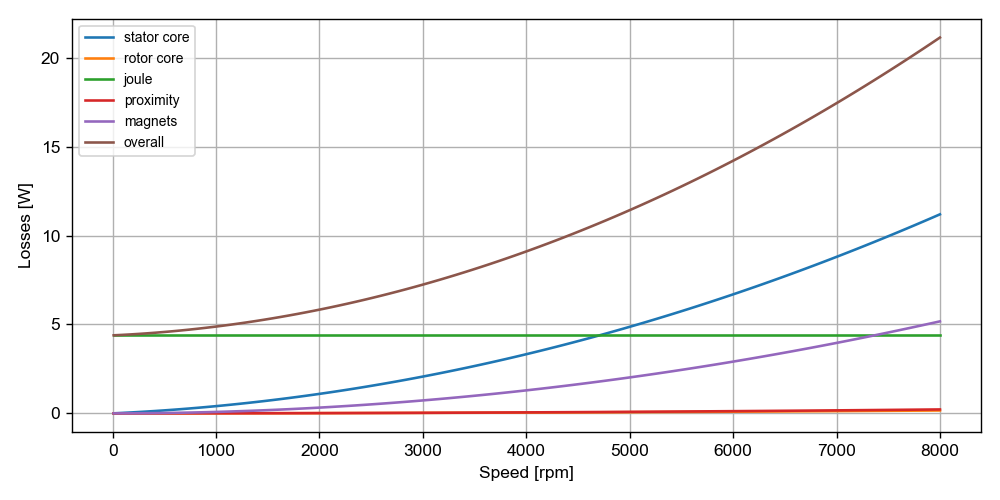

In [9]:
out.loss.plot_losses()

The loss meshsolution (values on the mesh) can also be shown to see where the losses are located in the machine for each loss model. All the results are stored in a different object here: 

In [10]:
for key in out.loss.loss_dict.keys():
    print(key)

stator core
rotor core
joule
proximity
magnets
overall


Then for each loss model, the solution on the full mesh can be plotted with:

In [11]:
out.loss.loss_dict["overall"].plot_mesh()  # overall on full mesh

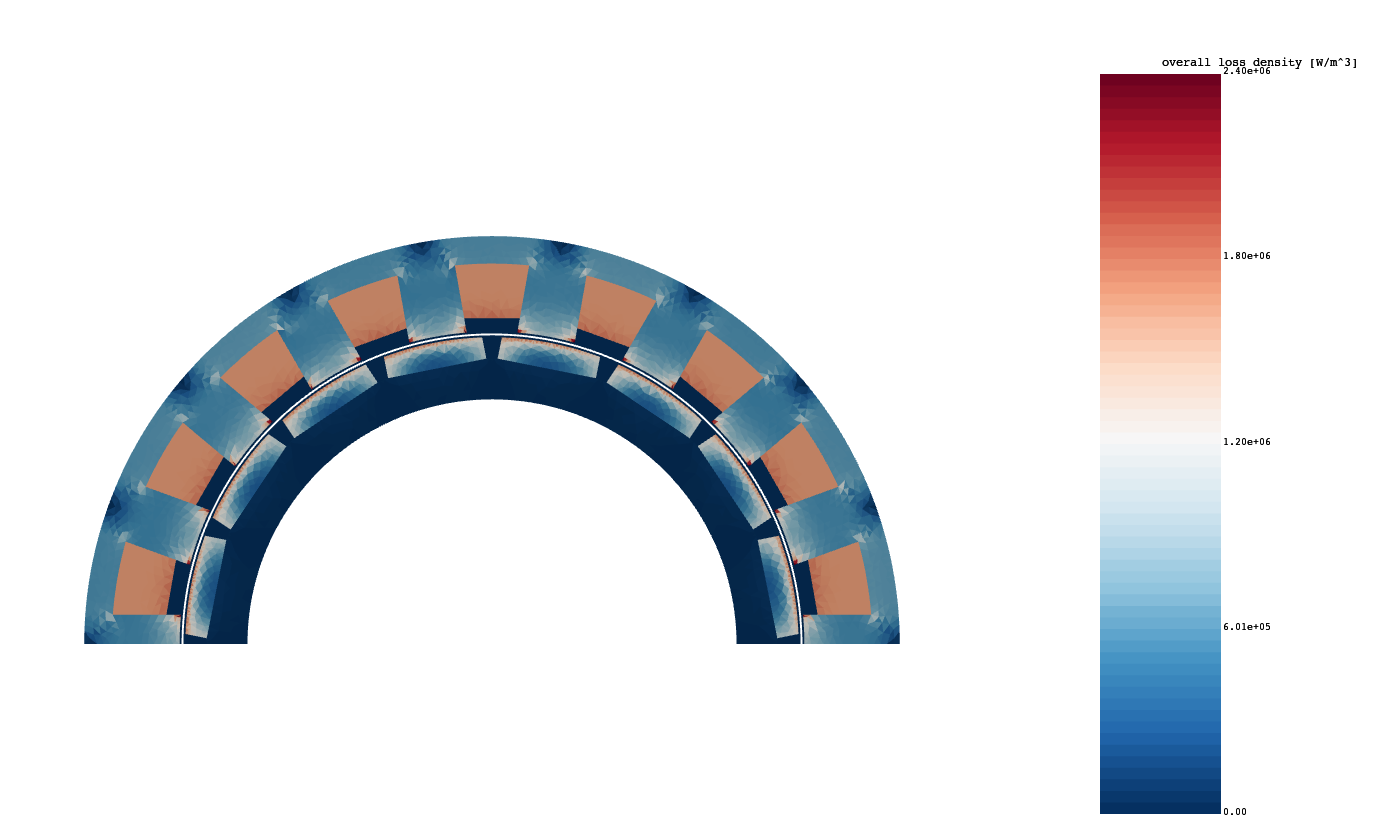
out.loss.loss_dict["overall"] can also be accessed as out.loss["overall"]

It is also possible to select the part(s) of the mesh to plot the losses on:

In [12]:
group_names = [
"stator core",
"rotor core",
"stator winding",
"rotor magnets",
]
out.loss["overall"].plot_mesh(group_names=["stator core", "stator winding"])  # Overall on stator
out.loss["overall"].plot_mesh(group_names=["rotor core", "rotor magnets"])  # rotor core with magnets

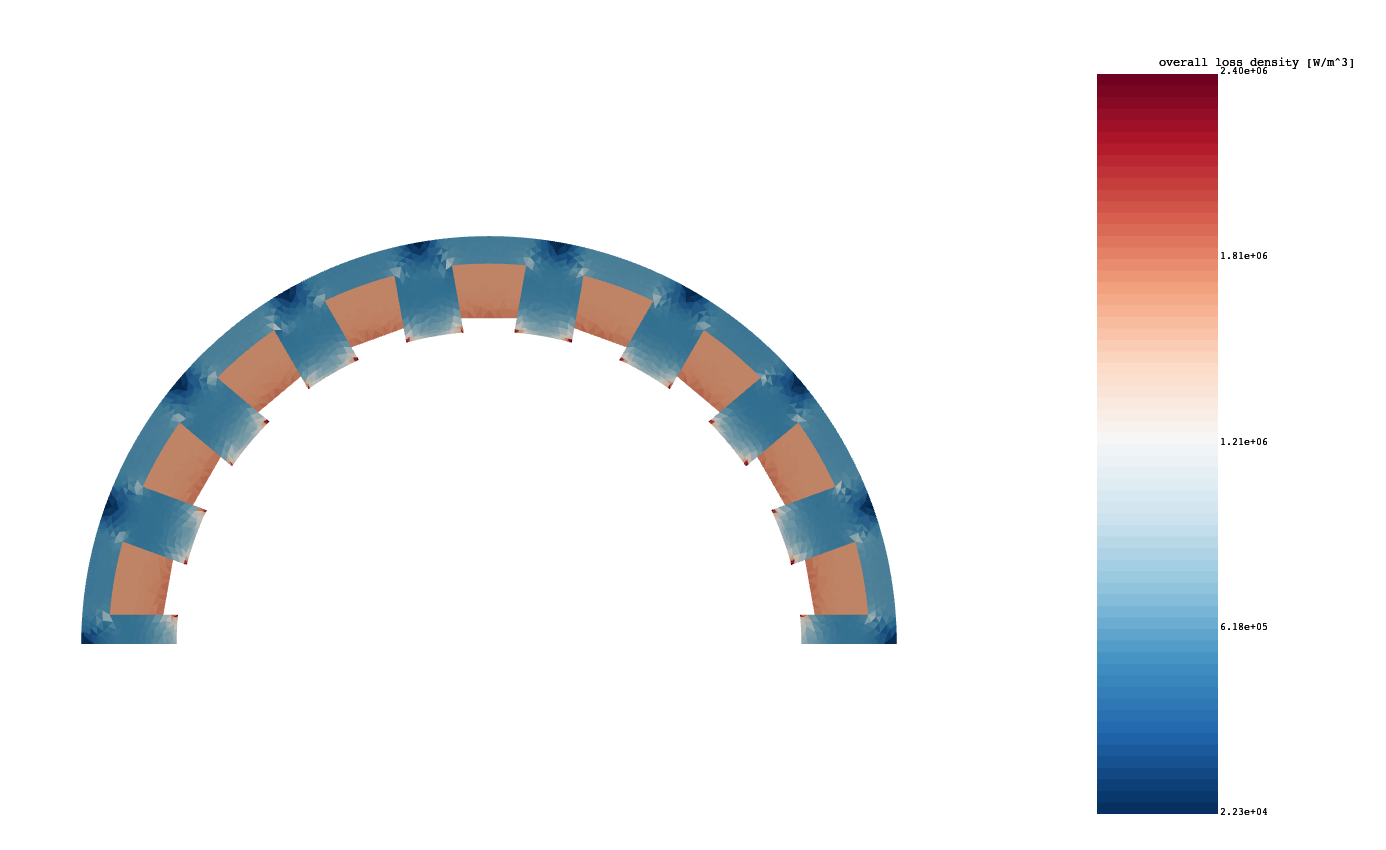
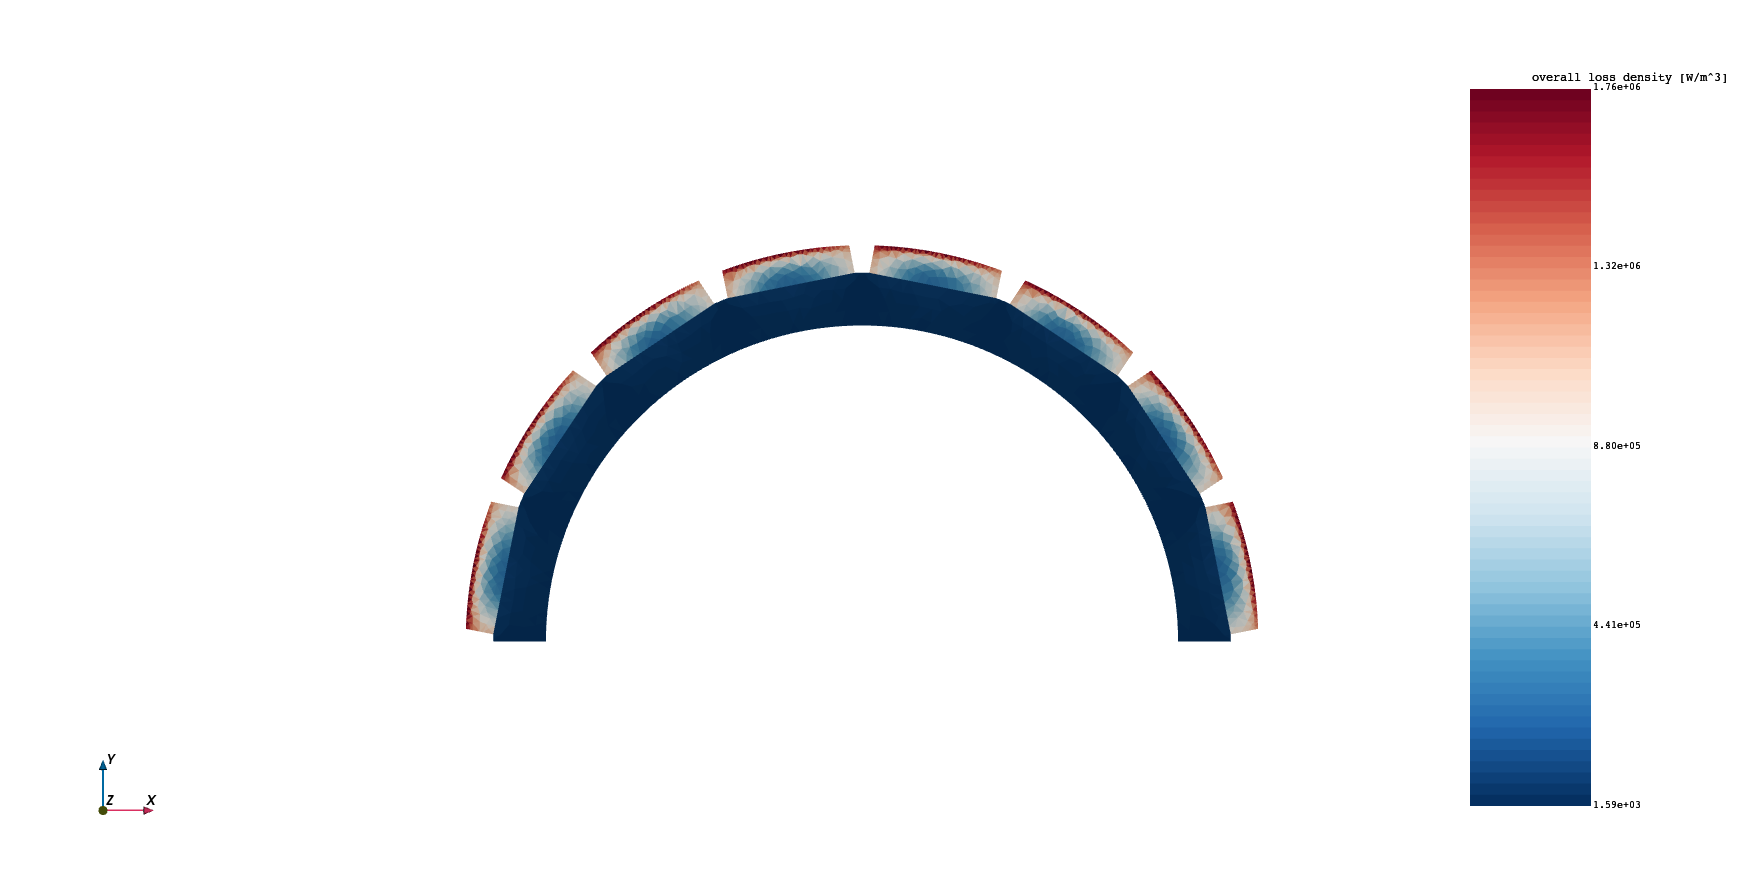

# Advanced: Loss model setup

In the first part of the tutorial, LossFEA automatically setup all the losses sub-model. In this second exemple, a Loss object is used to setup manually the losses sub-model. The machine used in this tutorial will be the Toyota Prius machine defined in the "[How to define a machine](https://pyleecan.org/01_tuto_Machine.html)" tutorial. 

<IPython.core.display.Javascript object>


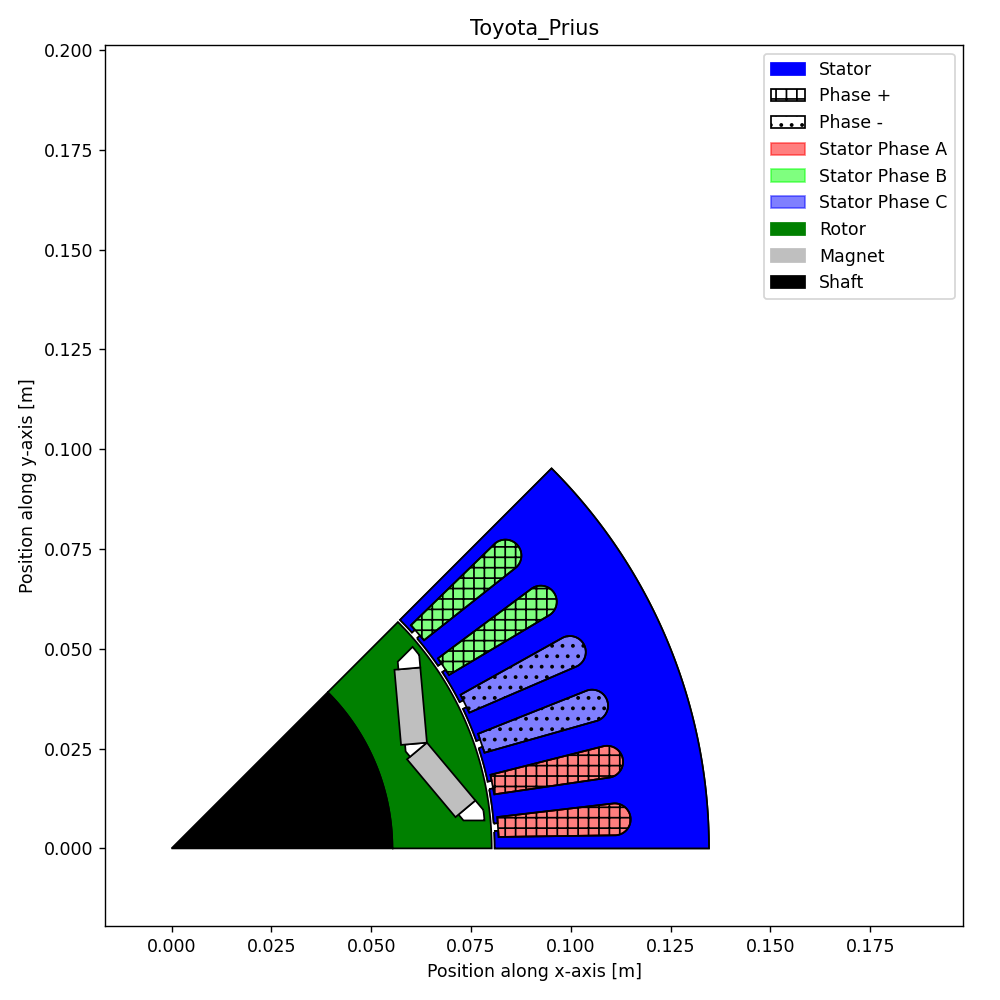

In [13]:
# Load the machine

machine = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
fig, ax = machine.plot(is_max_sym=True)

## Definition of the simulation

As previously a single operating point, current driven simulation is defined with FEMM to compute the flux:

In [14]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.Loss import Loss
from pyleecan.Classes.LossModelSteinmetz import LossModelSteinmetz
from pyleecan.Classes.LossModelBertotti import LossModelBertotti
from pyleecan.Classes.LossModelWinding import LossModelWinding
from pyleecan.Classes.LossModelProximity import LossModelProximity
from pyleecan.Classes.LossModelMagnet import LossModelMagnet
from pyleecan.Classes.OutLoss import OutLoss
import numpy as np

simu = Simu1(name="test_FEMM_Loss_Prius", machine=machine)


Ic = 230 * np.exp(1j * 140 * np.pi / 180)

simu.input = InputCurrent(
    Nt_tot=40 * 8,
    Na_tot=200 * 8,
    OP=OPdq(N0=1200, Id_ref=Ic.real, Iq_ref=Ic.imag),
    is_periodicity_t=True,
    is_periodicity_a=True,
)

simu.mag = MagFEMM(
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    is_get_meshsolution=True,
    is_fast_draw=True,
    is_calc_torque_energy=False,
)

The following loss object setup is the same as the one automaticcaly defined by LossFEA but it can be edited to add other models.

In [15]:
# A loss object is created. The models are set in dictionnary.
simu.loss = Loss(
    is_get_meshsolution=True,  # To be able to plot the losses on the mesh at the end
    Tsta=100,  # Stator temperature [°C]
    model_dict={"stator core": LossModelSteinmetz(group = "stator core"),
                "rotor core": LossModelSteinmetz(group = "rotor core"),
                "joule": LossModelWinding(group = "stator winding"),
                "proximity": LossModelProximity(group = "stator winding"),
                "magnets": LossModelMagnet(group = "rotor magnets")}
)

Once set up, the simulation can simply be run using the *run* method.

In [16]:
out2 = simu.run()

[16:35:00] Starting running simulation test_FEMM_Loss_Prius (machine=Toyota_Prius)
[16:35:00] Starting Magnetic module
[16:35:02] Solving time steps: 0%
[16:35:02] Solving time steps: 0%
[16:35:02] Solving time steps: 0%
[16:35:03] Solving time steps: 0%
[16:35:05] Solving time steps: 25%
[16:35:05] Solving time steps: 25%
[16:35:05] Solving time steps: 25%
[16:35:06] Solving time steps: 25%
[16:35:08] Solving time steps: 50%
[16:35:08] Solving time steps: 50%
[16:35:09] Solving time steps: 50%
[16:35:09] Solving time steps: 50%
[16:35:12] Solving time steps: 75%
[16:35:12] Solving time steps: 75%
[16:35:12] Solving time steps: 75%
[16:35:13] Solving time steps: 75%
[16:35:14] Solving time step: 100%
[16:35:14] Solving time step: 100%
[16:35:14] Solving time step: 100%
[16:35:15] Solving time step: 100%
[16:35:15] Running Loss module
[16:35:15] End of simulation test_FEMM_Loss_Prius


As before, all losses output are stored in out.loss and each model in out.loss.loss_dict

In [17]:
power_dict = out2.loss.get_power_dict()
for key, value in power_dict.items():
    print(key+": "+format(value, ".2f") +" [W]")

stator core: 292.64 [W]
rotor core: 14.81 [W]
joule: 7579.03 [W]
proximity: 16.83 [W]
magnets: 12.18 [W]
total_power: 54596.16 [W]


In [18]:
for key in out2.loss.loss_dict:
    print(key)

stator core
rotor core
joule
proximity
magnets


### Plotting the distribution of the losses in the machine
Losses as a function of speed is available with:

<IPython.core.display.Javascript object>


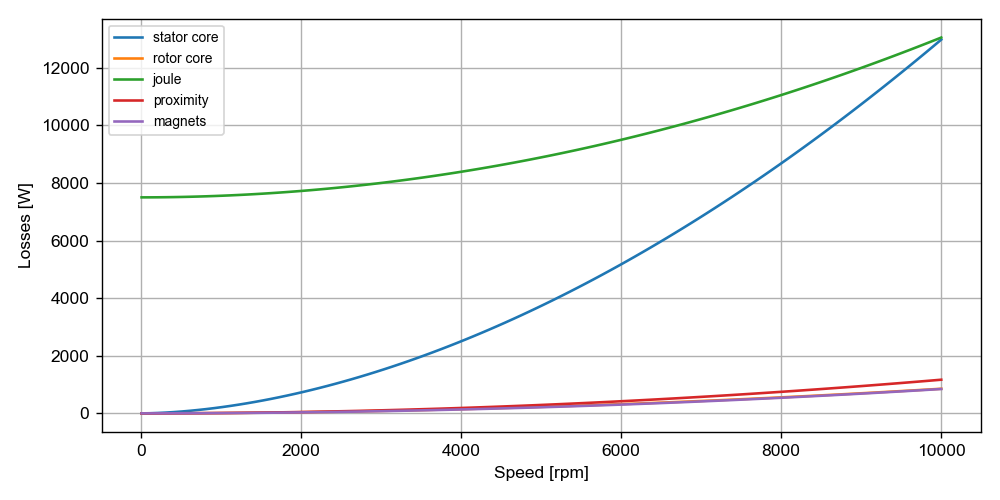

In [19]:
N0_array = np.linspace(10,10000,100)  # To enforce N0 axis
out2.loss.plot_losses(N0_array=N0_array)

The meshsolution is stored in the output of the simulation, allowing to plot the machine with the loss values in each elements. The loss values can be separated by each type of loss. The result can be summed to get the overall (which is automatically done for LossLEA)

In [20]:
All_core = out2.loss["stator core"] + out2.loss["rotor core"]
All_core.parent = out2.loss  # Needed to plot
All_core.plot_mesh(group_names=["stator core", "rotor core"])

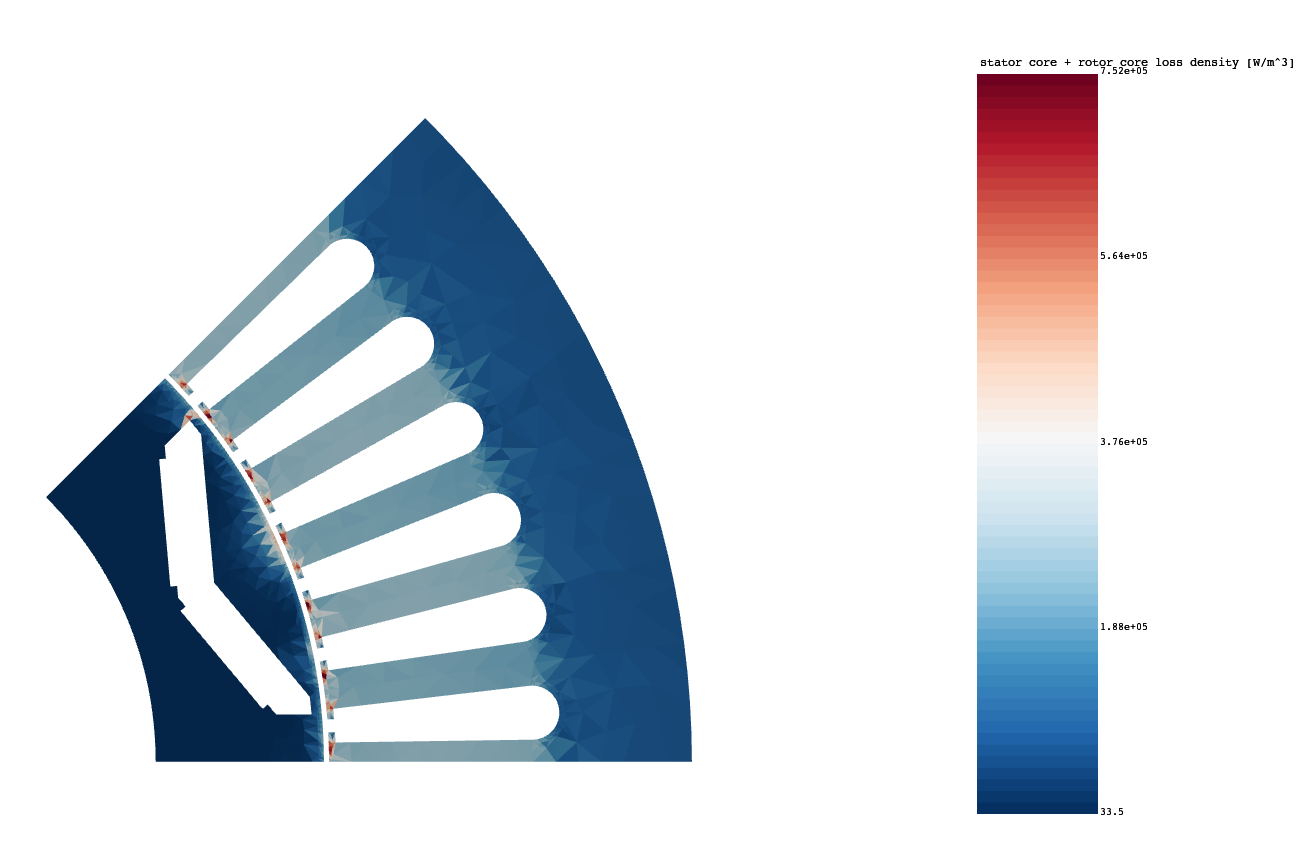